# Primer trazenja 'najbolje prave' na osnovu datih tačaka

Ako pretpostavimo da je model ponašanja nekog sistema opisan linearnom funkcijom

$ y = f(x) = ax+b$

zadatak pretrage je pronaći odgovarajuće a i b.


In [66]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


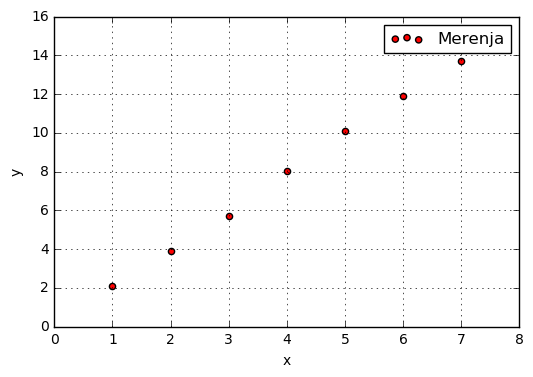

In [67]:
xm = np.array([1, 2, 3, 4, 5, 6, 7]).astype(np.float32)
ym = np.array([2.1, 3.9, 5.7, 8.01, 10.1, 11.9, 13.7]).astype(np.float32)


plt.scatter(xm, ym, c='r', label='Merenja')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


Ako pretpostavimo da je model ponašanja linearan onda možemo da postavimo početnu pretpostavku.

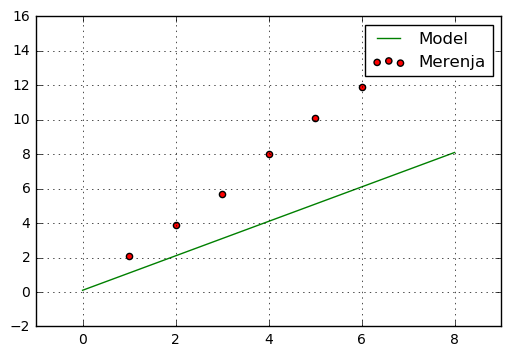

In [68]:
a = 1
b = 0.1

x_range = (0, 8)

plt.scatter(xm, ym, c='r', label='Merenja')
plt.plot(x_range, [a*xt+b for xt in x_range], c='g', label='Model')
plt.grid(True)
plt.legend()
plt.show()

Cilj pretrage je pronaći najbolje a i b.


Kao što smo ranije radili prvo dizajniramo klasu State.

## State

U klasi state implementiraćemo funkciju h koja treba da proveri koliko je stanje dobro. U ovom slučaju funkcija h nam vraća prosečnu vrednost kvadrata odstupanja merenih vrednosti od pretpostavljenog modela.

Manja vrednost funkcije h opisuje bolje stanje.


In [76]:
class State:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def h(self, niz):
        err = 0
        n = len(niz)
        for (xm, ym) in niz:
            yt = self.a*xm  + self.b
            err += (yt-ym)**2
        if(n!=0):
            return err/float(n)
        else:
            return 'Greska'
        
    def __str__(self):
        s = "{0}, {1}".format(self.a, self.b)
        return s

## Problem

Sledeći korak je definisanje klase Problem u kojoj ćemo implementirati tri funkcije:
- isGoal
- firstState
- akcije

##### isGoal 
Cilj je pronaći stanje (parametre a i b) takve da je greška u odnosu na model manja od 0.1

##### firstState
Izaberemo bilo koju tačku iz intervala koju ćemo koristiti za početak pretrage.

##### akcije
Na početku prvo definišemo parametre
- da: korak za promenu vrednosti parametra a
- db: korak za promenu vrednosti parametra b
- smerovi: smerovi u kojima pretraga može da se kreće

In [77]:
from copy import deepcopy

class Problem:
    def isGoal(self, state, niz):
        err = state.h(niz)
        if(err<0.1):
            return True
        else:
            return False
    
    def firstState(self, el):
        return State(el[0], el[1])
       
    def akcije(self, state):        
        ret = []
        da = 0.01
        db = 0.01
        smerovi = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        for ak in smerovi:
            s = deepcopy(state)
            state.a += ak[0]*da
            state.b += ak[1]*db
            ret.append(s)                    
        return ret


## Node

Klasa node treba samo da obezbedi elemente za formiranje stabla pretrage.

In [78]:
class Node:
    def __init__(self, parent, action, state):
        self.parent = parent
        self.action = action
        self.state = state
        
    def __str__(self):
        return str(self.state)
        
    def children(self):
        akcije = problem.akcije(self.state)
        ret = []
        for n in akcije:
            nnode = Node(self, '-', n)
            ret.append(nnode)
        return ret

## Algoritam

U ovom primeru nam nije bitan put kojim ćemo se kretati do rešenja već samo rešenje.

In [80]:
problem = Problem()    
start = problem.firstState([1, 0.1])
start_node = Node(None, None, start)


niz = np.array(zip(xm,ym))
print niz

front = [start_node]
seen = {}
count = 0
max_front = 1
while(len(front)>0):   
    node = front.pop(0)        
    max_front = max([max_front, len(front)])    
    if problem.isGoal(node.state, niz):
        print 'reseno'
        a = node.state.a
        b = node.state.b
        break
    key = str(node.state)
    if(key not in seen):
        seen[key] = node
        children = node.children()
        for child in children:
            #front.insert(0, child) # dodavanje na pocetak
            front.append(child) # dodavanje na kraj
    count += 1
print 'Broj koraka: {0}'.format(count)
print 'Max velicina fronta: {0}'.format(max_front)
print 'Rešenje {0}*x+{1}'.format(a, b)

[[  1.           2.0999999 ]
 [  2.           3.9000001 ]
 [  3.           5.69999981]
 [  4.           8.01000023]
 [  5.          10.10000038]
 [  6.          11.89999962]
 [  7.          13.69999981]]
reseno
Broj koraka: 16026
Max velicina fronta: 359
Rešenje 1.9*x+0.1


### Test 

Grafički test na kojem su prikazane i merene vrednosti i rezultujući model.

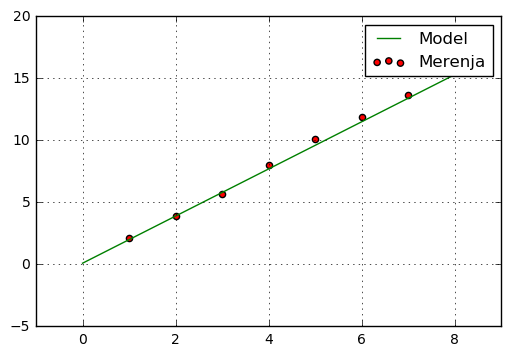

In [81]:
x_range = (0, 8)

plt.scatter(xm, ym, c='r', label='Merenja')
plt.plot(x_range, [a*xt+b for xt in x_range], c='g', label='Model')
plt.grid(True)
plt.legend()
plt.show()

# Vođene pretrage

Pošto imamo funkciju kojom možemo da ocenimo neko stanje, prilikom biranja čvora iz liste front možemo umesto prvog da uzimamo onog koji ima najmanju vrednost funkcije h (heuristička funkcija).

In [83]:
problem = Problem()    
start = problem.firstState([1, 0.1])
start_node = Node(None, None, start)


niz = np.array(zip(xm,ym))
print niz

front = [start_node]
seen = {}
count = 0
max_front = 1
while(len(front)>0):   
    #-----------------------------------------
    min_h = front[0].state.h(niz)
    min_el = 0
    for i in range(len(front)):
        h = front[i].state.h(niz)
        if h<min_h:
            min_h = h
            min_el = i
    node = front.pop(min_el)        
    #-----------------------------------------
    max_front = max([max_front, len(front)])    
    if problem.isGoal(node.state, niz):
        print 'reseno'
        a = node.state.a
        b = node.state.b
        break
    key = str(node.state)
    if(key not in seen):
        seen[key] = node
        children = node.children()
        for child in children:
            #front.insert(0, child) # dodavanje na pocetak
            front.append(child) # dodavanje na kraj
    count += 1
print 'Broj koraka: {0}'.format(count)
print 'Max velicina fronta: {0}'.format(max_front)
print 'Rešenje {0}*x+{1}'.format(a, b)

[[  1.           2.0999999 ]
 [  2.           3.9000001 ]
 [  3.           5.69999981]
 [  4.           8.01000023]
 [  5.          10.10000038]
 [  6.          11.89999962]
 [  7.          13.69999981]]
reseno
Broj koraka: 90
Max velicina fronta: 270
Rešenje 1.9*x+0.1


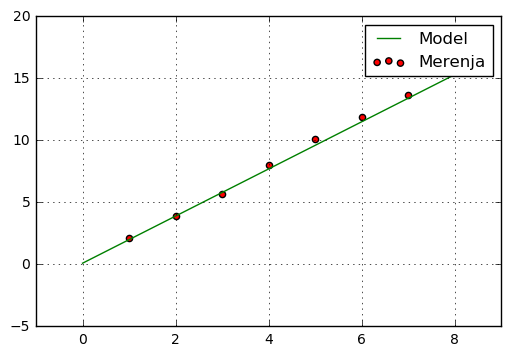

In [84]:
x_range = (0, 8)

plt.scatter(xm, ym, c='r', label='Merenja')
plt.plot(x_range, [a*xt+b for xt in x_range], c='g', label='Model')
plt.grid(True)
plt.legend()
plt.show()